In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import os
import numpy as np
import matplotlib.colors as mcolors
%matplotlib inline

In [2]:
def zfill(s, width):
    return s.zfill(width)

def fill_fips(df):
    indexes = df.index
    idx_list = []
    for i in indexes:
        if len(str(i)) == 4:
            i = zfill(str(i), 5)
        idx_list.append(i)

    # convert all elements to str
    idx_list = [str(i) for i in idx_list]
    df.index = idx_list

    return df
    

### DT Owner Count

In [3]:
oc = pd.read_csv('/mnt/gis-nfs/users/abreunig/superparcels/analysis/owner_count_analysis.csv', index_col=0)
oc = fill_fips(oc)
oc

,30,50,75,100,150,200
06091,106,111,111,113,115,118
55107,2367,2391,2403,2414,2425,2437
08031,1194,1240,1289,1308,1359,1399
06075,655,693,723,755,805,845
16001,2758,2855,2951,3003,3092,3133
35051,233,252,263,269,281,293
20097,224,232,239,244,251,254
41013,404,410,418,423,431,433
48113,5933,6204,6418,6554,6811,6977
06037,18313,18870,19321,19658,20194,20610


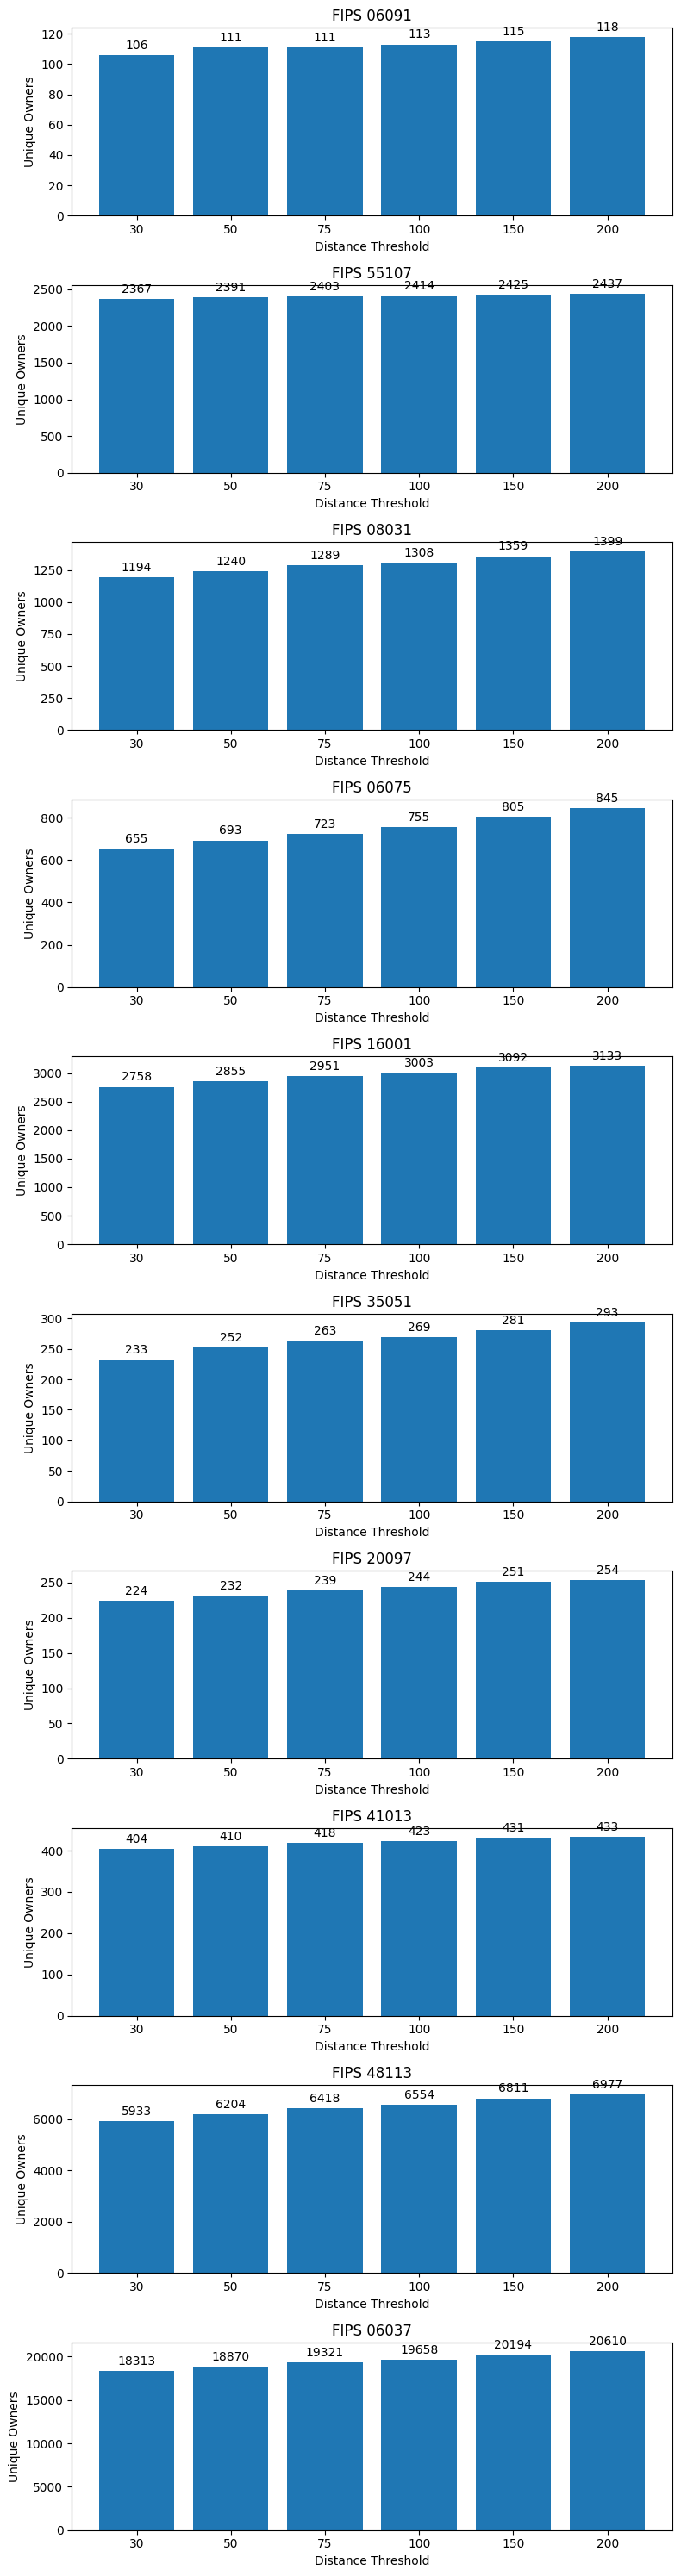

In [4]:
# Separate the index values and bar values
indexes = oc.index.to_list()
bar_values = oc.values

# Create one subplot for each row in the oc
nrows = oc.shape[0]
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(8, 3*nrows))

# In case there is only one row, ensure axes is iterable.
if nrows == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    # Create the bar plot for the current row
    bars = ax.bar(oc.columns.to_list(), bar_values[i])
   
    ax.bar_label(bars, padding=3)
    
    # Set the title of the subplot to show the index value
    ax.set_title(f"FIPS {indexes[i]}")
    
    # Optionally, label axes
    ax.set_xlabel("Distance Threshold")
    ax.set_ylabel("Unique Owners")

plt.tight_layout()
plt.show()


### DT Overlap

In [5]:
dt_overlap = pd.read_csv('/mnt/gis-nfs/users/abreunig/superparcels/analysis/dt_overlap_analysis.csv', index_col=0)
dt_overlap = fill_fips(dt_overlap)
dt_overlap

,30_overlaps,30_sp_count,30_pct_overlap,30_avg_overlap,50_overlaps,50_sp_count,50_pct_overlap,50_avg_overlap,75_overlaps,75_sp_count,...,100_pct_overlap,100_avg_overlap,150_overlaps,150_sp_count,150_pct_overlap,150_avg_overlap,200_overlaps,200_sp_count,200_pct_overlap,200_avg_overlap
06091,512.0,294.0,174.149660,2.522167,584,302,193.377483,2.630631,594,299,...,198.684211,2.637555,612,307,199.348534,2.626609,624,312,200.000000,2.632911
55107,22672.0,10956.0,206.936838,4.190758,23872,11028,216.467174,4.255258,9264,8262,...,116.968818,2.309234,10222,8255,123.827983,2.353673,7164,5501,130.230867,2.245064
08031,1592.0,3427.0,46.454625,1.941463,1828,3436,53.201397,2.024363,2102,3491,...,68.615210,2.134157,2942,3576,82.270694,2.268311,3532,3576,98.769575,2.417522
06075,1584.0,2780.0,56.978417,3.313808,2268,2807,80.798005,3.736409,950,1946,...,56.083086,2.111732,1478,2160,68.425926,2.176730,2138,2291,93.321694,2.339168
16001,NaN,NaN,NaN,NaN,5154,7295,70.651131,1.994582,5904,7347,...,89.426230,2.154707,7308,7342,99.536911,2.248615,8080,7381,109.470261,2.325180
35051,152.0,572.0,26.573427,1.567010,192,614,31.270358,1.573770,236,636,...,42.767296,1.638554,320,644,49.689441,1.675393,412,664,62.048193,1.731092
20097,492.0,543.0,90.607735,2.129870,524,562,93.238434,2.104418,580,577,...,103.247863,2.111888,710,596,119.127517,2.232704,806,607,132.784185,2.322767
41013,1118.0,1002.0,111.576846,2.353684,1214,1001,121.278721,2.442656,1238,1011,...,124.292683,2.435946,1370,1035,132.367150,2.437722,1436,1037,138.476374,2.446337
48113,7496.0,15095.0,49.658827,1.886261,9628,15402,62.511362,2.010441,11168,15769,...,78.772699,2.155955,15102,16416,91.995614,2.286450,17784,16842,105.593160,2.420250
06037,19332.0,47648.0,40.572532,1.824806,23744,47644,49.836286,1.958268,27432,48270,...,63.188073,2.100334,36538,49746,73.449122,2.196321,41298,50499,81.779837,2.281784


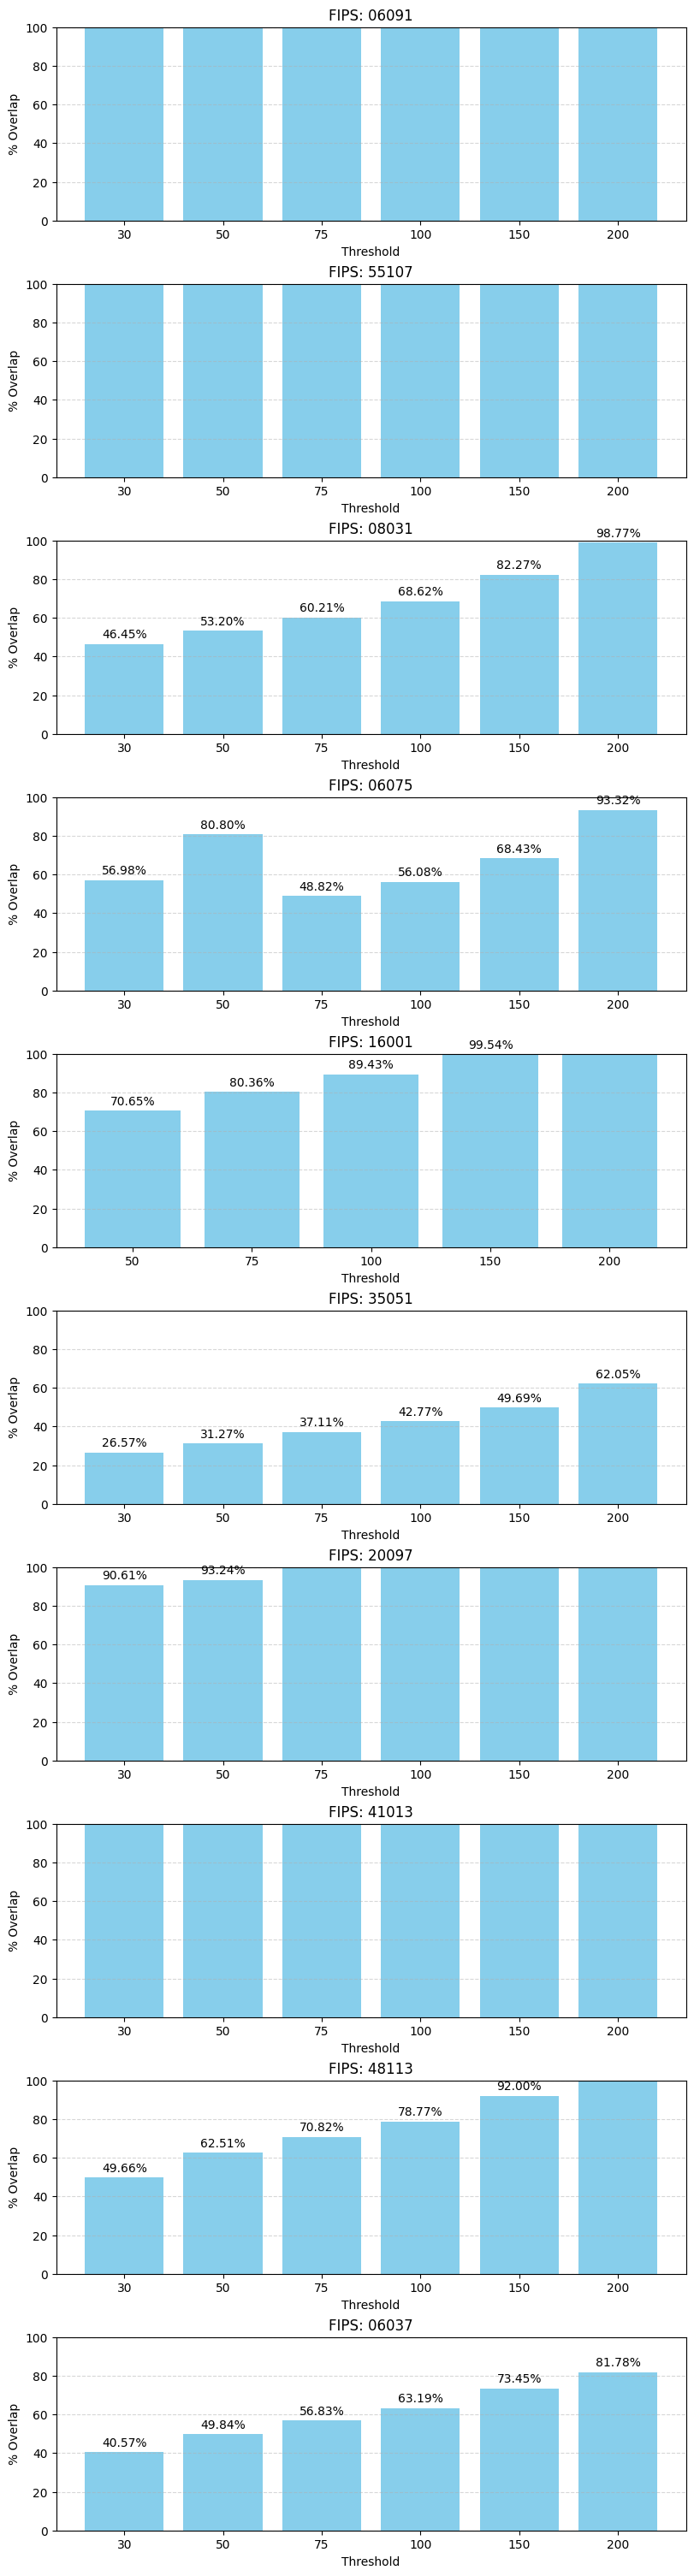

In [6]:
# Extract all thresholds based on column names that include 'pct_overlap'
thresholds = sorted([
    int(col.split('_')[0]) for col in dt_overlap.columns if 'pct_overlap' in col
])

# Plotting
num_fips = len(dt_overlap)
fig, axes = plt.subplots(num_fips, 1, figsize=(8, 3 * num_fips), constrained_layout=True)

if num_fips == 1:
    axes = [axes]  # Make iterable if only one

for ax, (fips, row) in zip(axes, dt_overlap.iterrows()):
    pct_overlaps = [row[f"{t}_pct_overlap"] for t in thresholds]
    threshold_labels = [str(t) for t in thresholds]

    bars = ax.bar(threshold_labels, pct_overlaps, color='skyblue')
    ax.set_title(f"FIPS: {fips}")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("% Overlap")
    ax.set_ylim(0, 100)  # Adjust if your values exceed 100
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Add bar labels
    ax.bar_label(bars, labels=[f"{val:.2f}%" for val in pct_overlaps], padding=3)

plt.show()


### DT Area Ratio

In [7]:
# read in the csv
area_ratio_df = pd.read_csv('/mnt/gis-nfs/users/abreunig/superparcels/analysis/dt_area_ratio_analysis.csv', index_col=0)
area_ratio_df = area_ratio_df[['fips', 'dt', 'area_ratio']].set_index('fips')
area_ratio_df = fill_fips(area_ratio_df)
area_ratio_df = area_ratio_df.reset_index().rename(columns={'index': 'fips'})

In [8]:
area_ratio_df['dt'].unique()

array([ 30,  50,  75, 100, 150, 200])

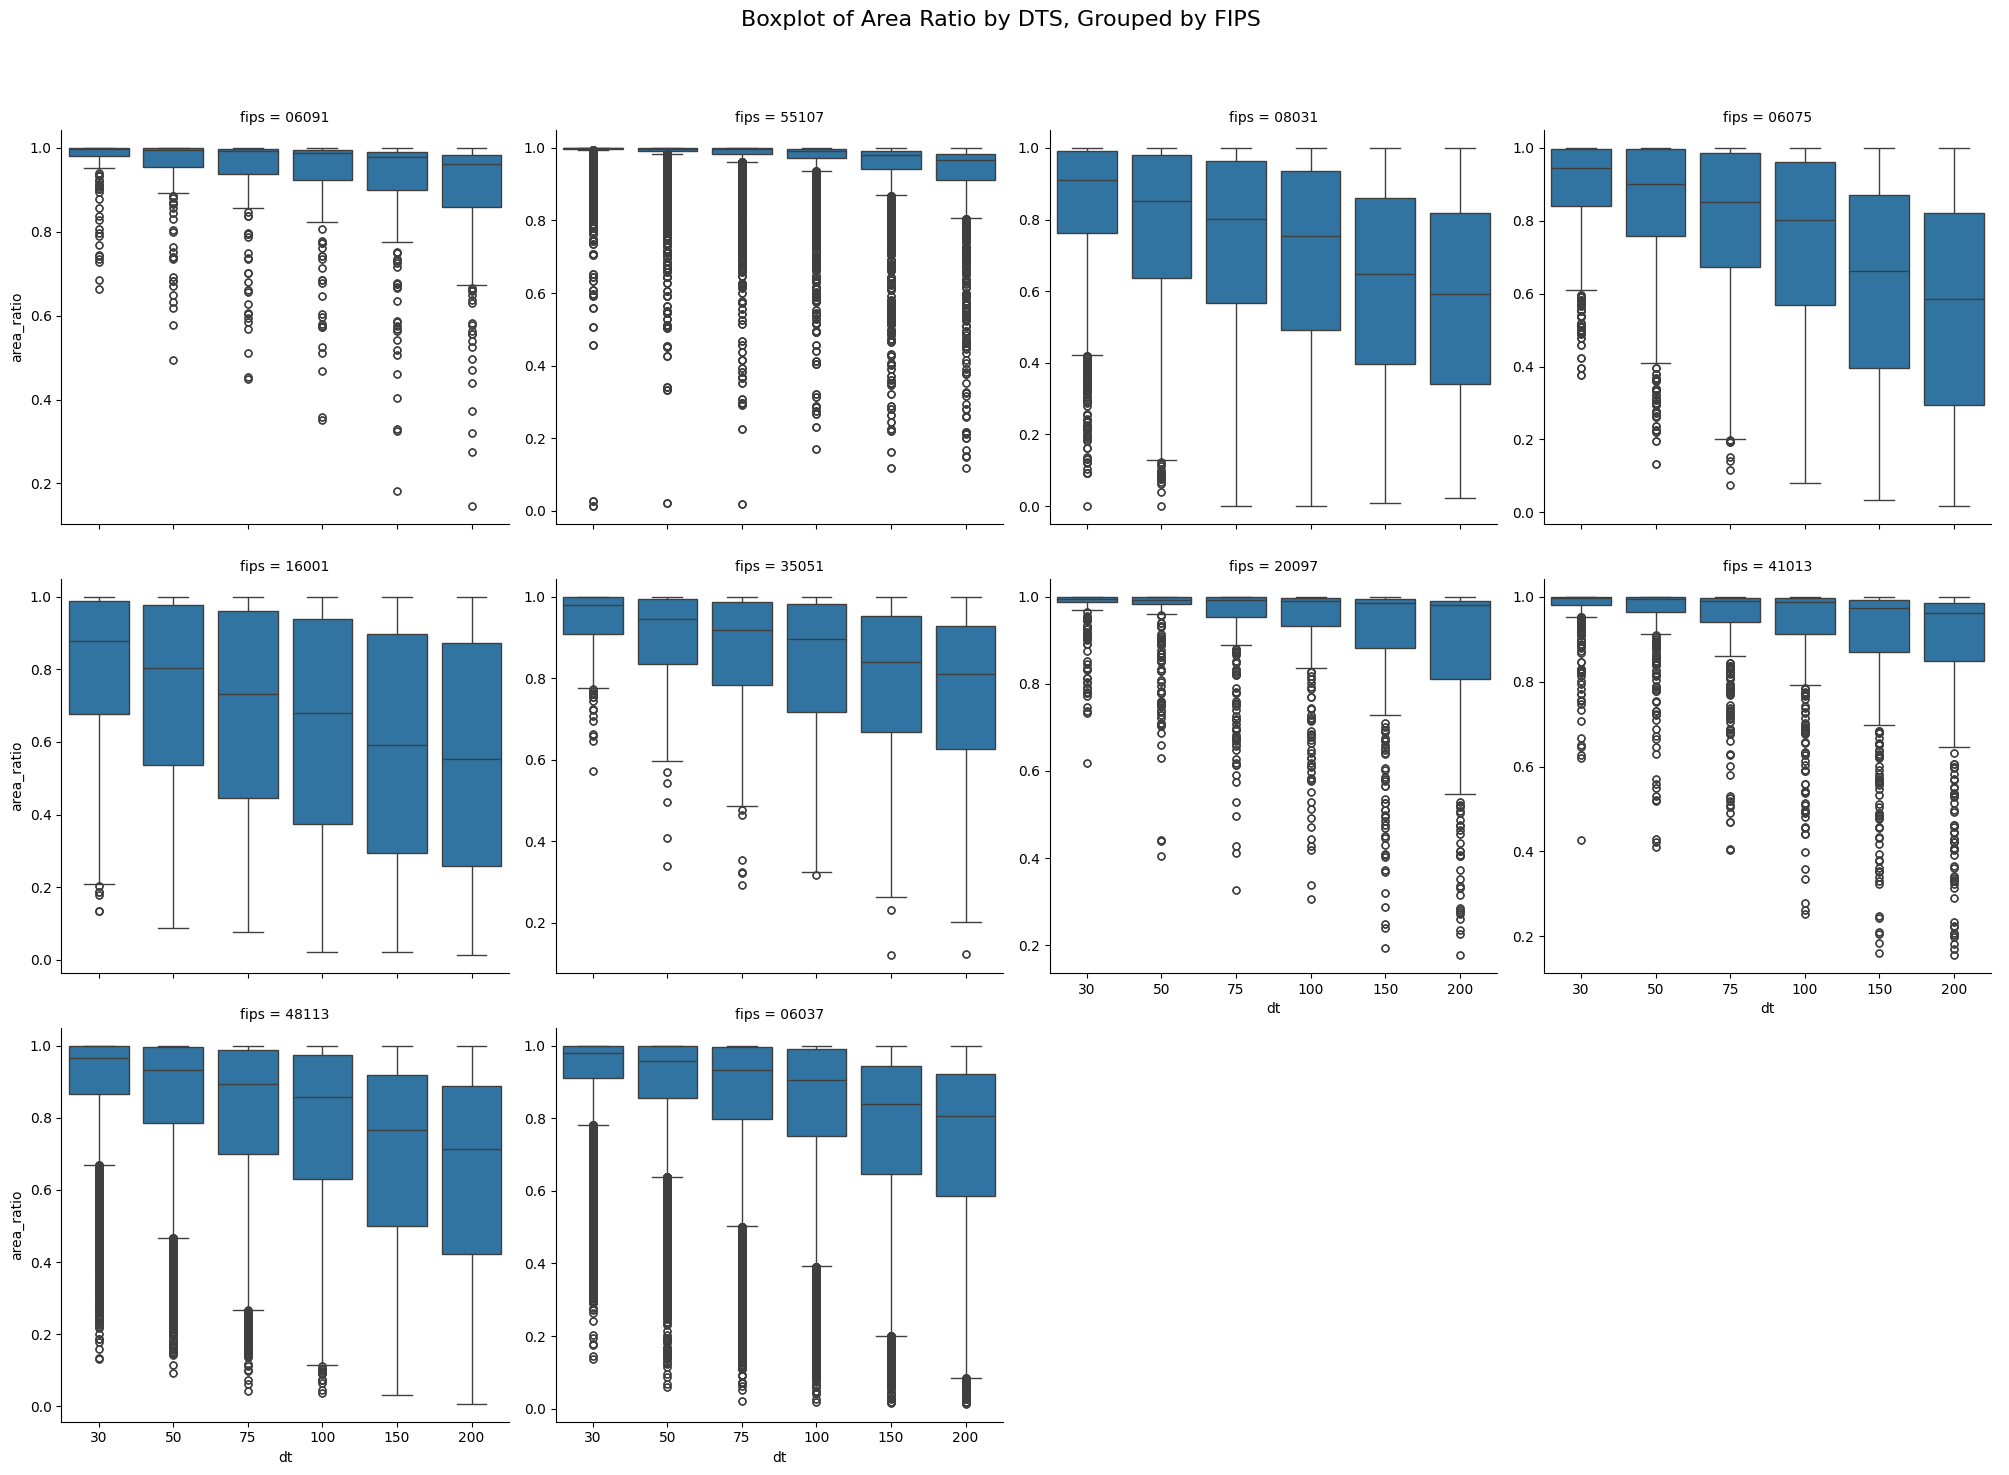

In [9]:

# Create one boxplot per FIPS
g = sns.catplot(
    data=area_ratio_df,  # Assuming this is your DataFrame
    x='dt',
    y='area_ratio',
    col='fips',             # One subplot per FIPS
    kind='box',
    col_wrap=4,             # Adjust this based on number of unique FIPS
    sharey=False            # Optional: make each FIPS plot scale independently
)

# Add a super title
g.figure.suptitle("Boxplot of Area Ratio by DTS, Grouped by FIPS", fontsize=16)

# Tweak spacing so title doesn't overlap
g.figure.tight_layout()
g.figure.subplots_adjust(top=0.9)


In [10]:
# Define bins and labels
bins = np.arange(0, 1.1, 0.1)  # 0.0 to 2.0 in steps of 0.1
labels = [f"{b:.1f}-{b+0.1:.1f}" for b in bins[:-1]]

# Bin the values
area_ratio_df['area_bin'] = pd.cut(area_ratio_df['area_ratio'], bins=bins, labels=labels, include_lowest=True)

bin_counts = (
    area_ratio_df.groupby(['dt', 'area_bin'])
    .size()
    .reset_index(name='count')
)

# Pivot to wide format
bin_pivot = bin_counts.pivot_table(
    index=['dt'],
    columns='area_bin',
    values='count',
    fill_value=0
).reset_index()

bin_percent = bin_pivot.copy()
area_cols = bin_pivot.columns.difference(['dt'])
bin_percent[area_cols] = np.round(bin_percent[area_cols].div(bin_percent[area_cols].sum(axis=1), axis=0) * 100,2)
bin_percent.sort_values(by='dt', inplace=True)
display(bin_percent)



/tmp/ipykernel_2285927/199001614.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_ratio_df.groupby(['dt', 'area_bin'])
/tmp/ipykernel_2285927/199001614.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  bin_pivot = bin_counts.pivot_table(


area_bin,dt,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
0,30,0.02,0.07,0.22,0.56,1.11,2.02,3.23,5.60,12.70,74.47
1,50,0.05,0.23,0.76,1.61,2.38,3.34,4.83,8.07,14.10,64.63
2,75,0.10,0.60,1.63,2.60,3.55,4.59,6.30,9.27,14.83,56.53
3,100,0.21,1.18,2.52,3.43,4.45,5.59,6.98,9.73,15.55,50.37
4,150,0.61,2.81,4.24,4.88,6.04,7.12,8.11,11.63,17.31,37.22
5,200,1.32,4.27,5.19,5.98,6.85,7.47,8.51,12.35,17.64,30.41
